In [ ]:
#vibo: https://www.kaggle.com/c/flowerdata-module5 (МИСИС)

In [1]:
#vibo: импортируем pytorch
import torch
from torch.nn import functional as F
from torchvision import datasets, models
import numpy as np

In [2]:
#vibo: устанавливаем torchvision
!pip install -U torch torchvision

In [3]:
#vibo: проверяем наличие GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
#vibo: проверяем версию pil
import PIL
print(PIL.PILLOW_VERSION)

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
#vibo: монтируем goolge drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
! pip install kaggle

In [7]:
!pip uninstall -y kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12


In [8]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 12.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [9]:
!pip install kaggle==1.5.6

     |████████████████████████████████| 58 kB 4.2 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=31fdc534ca2a0e1a281c0a89b25d4c07976c2cd523f4fc4c34b24ea19fac1fec
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [10]:
! mkdir ~/.kaggle

In [11]:
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
#vibo: скачиваем датасет с kaggle
! kaggle competitions download -c flowerdata-module5

 98% 291M/297M [00:07<00:00, 63.0MB/s]
100% 297M/297M [00:07<00:00, 42.8MB/s]


In [14]:
#vibo: разархивируем данные
!unzip -q /content/flowerdata-module5.zip

In [15]:
#vibo: проверяем наличие данных для обучения
!ls train

train


In [16]:
#vibo: обзор выделенной GPU
!nvidia-smi
#import torch
torch.cuda.is_available()

Wed Jan  5 21:39:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [17]:
#vibo: импортируем библиотеки
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [18]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [38]:
class FlowerDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        
        self.transform = transform    

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # # для преобразования изображений в тензоры PyTorch и нормализации входа
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # ])

        x = self.load_sample(self.files[index])
       #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)
  



In [20]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [22]:
#vibo: определяем папки для обучающей вцыборки (ниже ее разделим на train и val)
TRAIN_DIR = Path('./train/train')
#vibo: папка с объектами для test
TEST_DIR = Path('./test/test')

#vibo: файлы для train и val
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
#vibo: файлы для test
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [23]:
#vibo: объекты в папке для обучения (train + val) - 102 класса
!ls ./train/train

1    12  18  23  29  34  4   45  50  56  61  67  72  78  83  89  94
10   13  19  24  3   35  40  46  51  57  62  68  73  79  84  9	 95
100  14  2   25  30  36  41  47  52  58  63  69  74  8	 85  90  96
101  15  20  26  31  37  42  48  53  59  64  7	 75  80  86  91  97
102  16  21  27  32  38  43  49  54  6	 65  70  76  81  87  92  98
11   17  22  28  33  39  44  5	 55  60  66  71  77  82  88  93  99


In [24]:
#vibo: количество картинок на train+val
len(train_val_files)

6552

In [172]:
#vibo: test файлы
#!ls ./test/test

In [25]:
#vibo: количество картинок на тесте
len(test_files)

818

In [26]:
#vibo: base_line без балансировки классов
from sklearn.model_selection import train_test_split

#vibo: делим объекты на train и val для обучения и подбора гиперпараметров
train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=42)

In [27]:
#vibo: определим метки классов для train и val
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [66]:
# from sklearn.model_selection import train_test_split
# from random import shuffle
# import pandas as pd
# from itertools import chain

In [67]:
# #vibo: делаем балансировку классов
# ALL_LABELS = sorted(set(train_labels))
# train_dict = {lbl : [train_files[i] for i in range(len(train_files)) if train_labels[i]==lbl] for lbl in ALL_LABELS}
# split_dict = {lbl : [train_labels.count(lbl), val_labels.count(lbl)] for lbl in ALL_LABELS}
# split_dict = pd.DataFrame(data=split_dict, index=['Train_Count', 'Val_Count']).T

In [68]:
# split_dict

,Train_Count,Val_Count
1,20,7
10,28,10
100,26,9
101,37,12
102,27,9
...,...,...
95,76,25
96,54,18
97,40,14
98,51,17


In [69]:
# line = split_dict['Train_Count'].quantile()
# display('line: ', line)

'line: '

40.0

In [70]:
# #vibo: дополняем классы с малым количеством объектов
# for lbl in split_dict[split_dict['Train_Count'] < line].index:
#   train_dict[lbl] *= int(line // len(train_dict[lbl]) +1)

In [71]:
# #vibo: новый train
# train_files = list(chain.from_iterable(train_dict.values()))
# shuffle(train_files)
# train_labels = [path.parent.name for path in train_files]

In [72]:
# #vibo: проверяем что получилось
# new_dict = {lbl : [train_labels.count(lbl), val_labels.count(lbl)] for lbl in ALL_LABELS}
# new_dict = pd.DataFrame(data=new_dict, index=['Train_Count_New', 'Val_Count_New']).T 
# display(split_dict.merge(new_dict, how='left', left_index=True, right_index=True))

,Train_Count,Val_Count,Train_Count_New,Val_Count_New
1,20,7,60,7
10,28,10,56,10
100,26,9,52,9
101,37,12,74,12
102,27,9,54,9
...,...,...,...,...
95,76,25,76,25
96,54,18,54,18
97,40,14,40,14
98,51,17,51,17


In [39]:
#vibo: датасеты для передачи в класс FlowerDataset (формирование батчей и перевод картинок в тензоры)
#train_dataset = FlowerDataset(train_files, mode='train')
val_dataset = FlowerDataset(val_files, mode='val', transform = valid_dataset_transform)
#test_dataset = FlowerDataset(test_files, mode='test')

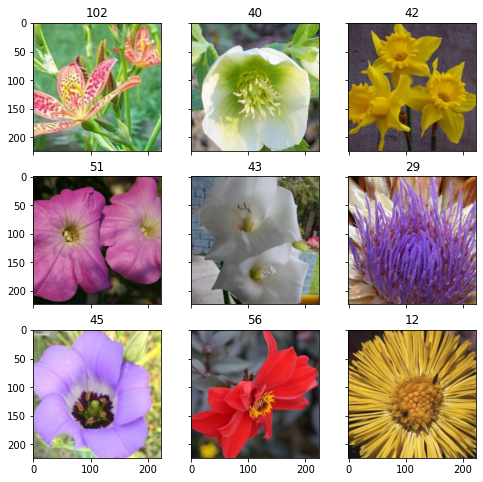

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [75]:
# #vibo: изм.1 фитчеэкстрактор: батчнорм, размер фильтра свертки, страйд, паддинг, классификатор: доп.слои
# class CNN(nn.Module):
  
#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=128,  kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
#         self.fc1 = nn.Sequential(
#             nn.Linear(6 * 6 * 128, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#         )        
        
#         self.fc3 = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#         )

#         self.out = nn.Sequential(
#             nn.Linear(1024, n_classes)
#         )
  
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         #vibo: изменяем размер для предачи на классификатор
#         x = F.interpolate(x, size=(6, 6), mode='bilinear', align_corners = True)
#         x = x.view(x.size(0), 6 * 6 * 128)

#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         logits = self.out(x)
#         return logits

In [42]:
#vibo: base fit_epoch
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [43]:
#vibo: base eval_epoch
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [58]:
#vibo: меняем Adam на AdamW
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = 3e-5)
        #opt = torch.optim.Adam(model.parameters(), lr = 3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [45]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [80]:
# n_classes = len(np.unique(train_val_labels))
# CNN = CNN(n_classes).to(DEVICE)
# print("we will classify :{}".format(n_classes))
# print(CNN)

we will classify :102
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5):

Запустим обучение сети.

In [41]:
if val_dataset is None:
    val_dataset = FlowerDataset(val_files, mode='val', transform = valid_dataset_transform)
    
train_dataset = FlowerDataset(train_files, mode='train', transform = train_dataset_transform)

In [ ]:
#bas-line-01 без баланисировки классов (AdamW lr=1e-4)
#history = train(train_dataset, val_dataset, model=CNN, epochs=20, batch_size=32)
#Epoch 020 train_loss: 0.1398     val_loss 2.4698 train_acc 0.9562 val_acc 0.5604
#make_accuracy_score(model=CNN) 0.609
#kaggle = 0.566

In [ ]:
# #base_line_02_c балансировкой классов (AdamW lr=1e-4)
# history = train(train_dataset, val_dataset, model=CNN, epochs=20, batch_size=32)
# Epoch 020 train_loss: 0.1294     val_loss 2.6569 train_acc 0.9603 val_acc 0.5433
# #make_accuracy_score(model=CNN) 0.558
# #kaggle = 0.564
# #vibo: балансировка привела к ухудшению score

In [138]:
#vibo: пробуем другую модель, предобученную
from torchvision import models

net = models.resnet34(pretrained=True)
# for parameter in net.parameters():
#     parameter.requres_grad = False
net.fc = torch.nn.Linear(512, n_classes)
net = net.to(DEVICE)

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [113]:
# #vibo: base_line_flower_03.csv
# #vibo: AdamW (lr=3e-4), без for parameter in net.parameters(): parameter.requres_grad = False, т.е. просто стартовали из загруженных весов
# net = net.to(DEVICE)
# history = train(train_dataset, val_dataset, model=net, epochs=20, batch_size=32)
# #Epoch 020 train_loss: 0.1011     val_loss 0.4921 train_acc 0.9725 val_acc 0.8889
# #make_accuracy_score(model=net -> resnet34) = 0.892
# #kaggle = 0.861

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.1711776109631482


epoch:   5%|▌         | 1/20 [02:50<53:58, 170.47s/it]


Epoch 001 train_loss: 1.1712     val_loss 0.6769 train_acc 0.7648 val_acc 0.8187
loss 1.8774863609946393


epoch:  10%|█         | 2/20 [05:39<50:49, 169.43s/it]


Epoch 002 train_loss: 1.8775     val_loss 1.5316 train_acc 0.5324 val_acc 0.5958
loss 0.5931403876202183


epoch:  15%|█▌        | 3/20 [08:26<47:47, 168.66s/it]


Epoch 003 train_loss: 0.5931     val_loss 0.7295 train_acc 0.8297 val_acc 0.8077
loss 0.3251438616447958


epoch:  20%|██        | 4/20 [11:14<44:52, 168.26s/it]


Epoch 004 train_loss: 0.3251     val_loss 0.6346 train_acc 0.9053 val_acc 0.8284
loss 0.278852513042047


epoch:  25%|██▌       | 5/20 [14:03<42:06, 168.45s/it]


Epoch 005 train_loss: 0.2789     val_loss 0.7741 train_acc 0.9233 val_acc 0.8089
loss 0.17415071292920573


epoch:  30%|███       | 6/20 [16:51<39:18, 168.48s/it]


Epoch 006 train_loss: 0.1742     val_loss 0.8353 train_acc 0.9494 val_acc 0.8077
loss 0.12719035026950148


epoch:  35%|███▌      | 7/20 [19:38<36:24, 168.02s/it]


Epoch 007 train_loss: 0.1272     val_loss 0.5340 train_acc 0.9651 val_acc 0.8578
loss 0.17147131070022775


epoch:  40%|████      | 8/20 [22:25<33:31, 167.61s/it]


Epoch 008 train_loss: 0.1715     val_loss 0.6005 train_acc 0.9527 val_acc 0.8455
loss 0.1676087905472108


epoch:  45%|████▌     | 9/20 [25:14<30:47, 167.97s/it]


Epoch 009 train_loss: 0.1676     val_loss 0.5580 train_acc 0.9502 val_acc 0.8504
loss 0.16693654452623768


epoch:  50%|█████     | 10/20 [28:03<28:03, 168.32s/it]


Epoch 010 train_loss: 0.1669     val_loss 0.6987 train_acc 0.9556 val_acc 0.8407
loss 0.1889366325093922


epoch:  55%|█████▌    | 11/20 [30:52<25:15, 168.39s/it]


Epoch 011 train_loss: 0.1889     val_loss 0.6121 train_acc 0.9443 val_acc 0.8578
loss 0.11842270845877517


epoch:  60%|██████    | 12/20 [33:40<22:26, 168.25s/it]


Epoch 012 train_loss: 0.1184     val_loss 0.7017 train_acc 0.9657 val_acc 0.8352
loss 0.08983721948247282


epoch:  65%|██████▌   | 13/20 [36:28<19:38, 168.34s/it]


Epoch 013 train_loss: 0.0898     val_loss 0.4238 train_acc 0.9775 val_acc 0.8974
loss 0.07025313286264871


epoch:  70%|███████   | 14/20 [39:18<16:52, 168.83s/it]


Epoch 014 train_loss: 0.0703     val_loss 0.7297 train_acc 0.9818 val_acc 0.8242
loss 0.12731815882976108


epoch:  75%|███████▌  | 15/20 [42:07<14:04, 168.90s/it]


Epoch 015 train_loss: 0.1273     val_loss 0.5440 train_acc 0.9672 val_acc 0.8712
loss 0.08263763078605856


epoch:  80%|████████  | 16/20 [44:56<11:14, 168.75s/it]


Epoch 016 train_loss: 0.0826     val_loss 0.6863 train_acc 0.9776 val_acc 0.8462
loss 0.1047977218668976


epoch:  85%|████████▌ | 17/20 [47:43<08:25, 168.39s/it]


Epoch 017 train_loss: 0.1048     val_loss 0.7451 train_acc 0.9724 val_acc 0.8156
loss 0.127550921470386


epoch:  90%|█████████ | 18/20 [50:31<05:36, 168.37s/it]


Epoch 018 train_loss: 0.1276     val_loss 0.7795 train_acc 0.9638 val_acc 0.8217
loss 0.23668205285851387


epoch:  95%|█████████▌| 19/20 [53:18<02:47, 167.97s/it]


Epoch 019 train_loss: 0.2367     val_loss 0.7514 train_acc 0.9402 val_acc 0.8236
loss 0.10109173128070834


epoch: 100%|██████████| 20/20 [56:05<00:00, 168.28s/it]


Epoch 020 train_loss: 0.1011     val_loss 0.4921 train_acc 0.9725 val_acc 0.8889


In [47]:
#vibo: пробуем другую модель, предобученную
from torchvision import models
n_classes = len(np.unique(train_val_labels))
net = models.efficientnet_b0(pretrained=True)
# for parameter in net.parameters():
#     parameter.requres_grad = False
net.fc = torch.nn.Linear(512, n_classes)
net = net.to(DEVICE)

net

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [141]:
# #vibo: base_line_flower_04.csv, model -> efficientnet
history = train(train_dataset, val_dataset, model=net, epochs=10, batch_size=32)
#Epoch 010 train_loss: 0.0658     val_loss 0.4764 train_acc 0.9834 val_acc 0.9017
#make_accuracy_score = 0.903
#kaggle = 0.884

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.9811693283664777


epoch:  10%|█         | 1/10 [02:48<25:12, 168.04s/it]


Epoch 001 train_loss: 1.9812     val_loss 0.2570 train_acc 0.6396 val_acc 0.9328
loss 0.27492920665989307


epoch:  20%|██        | 2/10 [05:34<22:17, 167.13s/it]


Epoch 002 train_loss: 0.2749     val_loss 0.3642 train_acc 0.9230 val_acc 0.9048
loss 0.09033654661989664


epoch:  30%|███       | 3/10 [08:20<19:27, 166.72s/it]


Epoch 003 train_loss: 0.0903     val_loss 0.3211 train_acc 0.9721 val_acc 0.9133
loss 0.05745718832821977


epoch:  40%|████      | 4/10 [11:06<16:39, 166.51s/it]


Epoch 004 train_loss: 0.0575     val_loss 0.3165 train_acc 0.9820 val_acc 0.9078
loss 0.04751581143425746


epoch:  50%|█████     | 5/10 [13:51<13:48, 165.65s/it]


Epoch 005 train_loss: 0.0475     val_loss 0.3618 train_acc 0.9851 val_acc 0.9206
loss 0.04210531069472512


epoch:  60%|██████    | 6/10 [16:34<10:59, 164.85s/it]


Epoch 006 train_loss: 0.0421     val_loss 0.3595 train_acc 0.9884 val_acc 0.9139
loss 0.046751526990793796


epoch:  70%|███████   | 7/10 [19:17<08:12, 164.32s/it]


Epoch 007 train_loss: 0.0468     val_loss 0.2444 train_acc 0.9874 val_acc 0.9328
loss 0.05132084657857787


epoch:  80%|████████  | 8/10 [22:01<05:28, 164.16s/it]


Epoch 008 train_loss: 0.0513     val_loss 0.2839 train_acc 0.9856 val_acc 0.9328
loss 0.06044949615960874


epoch:  90%|█████████ | 9/10 [24:45<02:44, 164.01s/it]


Epoch 009 train_loss: 0.0604     val_loss 0.2749 train_acc 0.9831 val_acc 0.9310
loss 0.06580113430012471


epoch: 100%|██████████| 10/10 [27:30<00:00, 165.04s/it]


Epoch 010 train_loss: 0.0658     val_loss 0.4764 train_acc 0.9834 val_acc 0.9017


In [184]:
# #vibo: base_line_flower_05.csv, model -> efficientnet b0 (без ручной балансировки классов)
history = train(train_dataset, val_dataset, model=net, epochs=10, batch_size=32)
#kaggle = 0.874

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.474292676248442


epoch:  10%|█         | 1/10 [02:11<19:47, 131.92s/it]


Epoch 001 train_loss: 2.4743     val_loss 0.3748 train_acc 0.5495 val_acc 0.9017
loss 0.3752482466135852


epoch:  20%|██        | 2/10 [04:22<17:26, 130.87s/it]


Epoch 002 train_loss: 0.3752     val_loss 0.5302 train_acc 0.8980 val_acc 0.8462
loss 0.12614134870284593


epoch:  30%|███       | 3/10 [06:31<15:12, 130.38s/it]


Epoch 003 train_loss: 0.1261     val_loss 0.3025 train_acc 0.9621 val_acc 0.9182
loss 0.07593498053768324


epoch:  40%|████      | 4/10 [08:41<12:59, 129.94s/it]


Epoch 004 train_loss: 0.0759     val_loss 0.2885 train_acc 0.9758 val_acc 0.9170
loss 0.05982981270101827


epoch:  50%|█████     | 5/10 [10:50<10:48, 129.79s/it]


Epoch 005 train_loss: 0.0598     val_loss 0.3483 train_acc 0.9819 val_acc 0.9194
loss 0.042184932655656746


epoch:  60%|██████    | 6/10 [13:00<08:38, 129.72s/it]


Epoch 006 train_loss: 0.0422     val_loss 0.2996 train_acc 0.9882 val_acc 0.9145
loss 0.056059892830242944


epoch:  70%|███████   | 7/10 [15:09<06:28, 129.56s/it]


Epoch 007 train_loss: 0.0561     val_loss 0.2733 train_acc 0.9843 val_acc 0.9243
loss 0.05073712889152842


epoch:  80%|████████  | 8/10 [17:18<04:19, 129.51s/it]


Epoch 008 train_loss: 0.0507     val_loss 0.3604 train_acc 0.9839 val_acc 0.9139
loss 0.06968797553834037


epoch:  90%|█████████ | 9/10 [19:27<02:09, 129.37s/it]


Epoch 009 train_loss: 0.0697     val_loss 0.2951 train_acc 0.9794 val_acc 0.9286
loss 0.04150395605647364


epoch: 100%|██████████| 10/10 [21:37<00:00, 129.71s/it]


Epoch 010 train_loss: 0.0415     val_loss 0.5202 train_acc 0.9892 val_acc 0.8736


In [48]:
# #vibo: base_line_flower_6.csv, model -> efficientnet b0 (без ручной балансировки классов) + переделеали transform, AdamW lr 3e-4
history = train(train_dataset, val_dataset, model=net, epochs=10, batch_size=32)
#kaggle = 0.952

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.884479328244015


epoch:  10%|█         | 1/10 [02:00<18:00, 120.00s/it]


Epoch 001 train_loss: 2.8845     val_loss 0.4064 train_acc 0.4652 val_acc 0.9048
loss 0.7489878280307396


epoch:  20%|██        | 2/10 [03:59<15:55, 119.47s/it]


Epoch 002 train_loss: 0.7490     val_loss 0.4146 train_acc 0.8012 val_acc 0.8883
loss 0.4275153592125788


epoch:  30%|███       | 3/10 [05:58<13:57, 119.58s/it]


Epoch 003 train_loss: 0.4275     val_loss 0.3006 train_acc 0.8787 val_acc 0.9188
loss 0.3099532608074729


epoch:  40%|████      | 4/10 [07:57<11:56, 119.38s/it]


Epoch 004 train_loss: 0.3100     val_loss 0.1782 train_acc 0.9155 val_acc 0.9512
loss 0.274452001911671


epoch:  50%|█████     | 5/10 [09:56<09:55, 119.17s/it]


Epoch 005 train_loss: 0.2745     val_loss 0.1766 train_acc 0.9251 val_acc 0.9536
loss 0.24567977892137127


epoch:  60%|██████    | 6/10 [11:55<07:56, 119.02s/it]


Epoch 006 train_loss: 0.2457     val_loss 0.1934 train_acc 0.9326 val_acc 0.9487
loss 0.2359235721595182


epoch:  70%|███████   | 7/10 [13:53<05:56, 118.77s/it]


Epoch 007 train_loss: 0.2359     val_loss 0.2611 train_acc 0.9363 val_acc 0.9341
loss 0.23662527968540734


epoch:  80%|████████  | 8/10 [15:51<03:57, 118.60s/it]


Epoch 008 train_loss: 0.2366     val_loss 0.0908 train_acc 0.9343 val_acc 0.9713
loss 0.198413819450647


epoch:  90%|█████████ | 9/10 [17:49<01:58, 118.32s/it]


Epoch 009 train_loss: 0.1984     val_loss 0.1787 train_acc 0.9463 val_acc 0.9499
loss 0.21982359527134537


epoch: 100%|██████████| 10/10 [19:47<00:00, 118.79s/it]


Epoch 010 train_loss: 0.2198     val_loss 0.1735 train_acc 0.9402 val_acc 0.9499


In [59]:
# #vibo: base_line_flower_7.csv, model -> efficientnet b0 (без ручной балансировки классов) + переделеали transform, AdamW lr 3e-5
history = train(train_dataset, val_dataset, model=net, epochs=10, batch_size=32)
#kaggle = 0.975

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.12438315888791446


epoch:  10%|█         | 1/10 [01:56<17:24, 116.02s/it]


Epoch 001 train_loss: 0.1244     val_loss 0.0713 train_acc 0.9664 val_acc 0.9805
loss 0.08844509751367843


epoch:  20%|██        | 2/10 [03:53<15:33, 116.69s/it]


Epoch 002 train_loss: 0.0884     val_loss 0.0612 train_acc 0.9770 val_acc 0.9811
loss 0.08419457498562966


epoch:  30%|███       | 3/10 [05:49<13:36, 116.61s/it]


Epoch 003 train_loss: 0.0842     val_loss 0.0672 train_acc 0.9788 val_acc 0.9835
loss 0.07645734191047181


epoch:  40%|████      | 4/10 [07:46<11:39, 116.55s/it]


Epoch 004 train_loss: 0.0765     val_loss 0.0638 train_acc 0.9796 val_acc 0.9811
loss 0.07859800365251896


epoch:  50%|█████     | 5/10 [09:43<09:44, 116.97s/it]


Epoch 005 train_loss: 0.0786     val_loss 0.0629 train_acc 0.9794 val_acc 0.9847
loss 0.06851710368744861


epoch:  60%|██████    | 6/10 [11:42<07:49, 117.45s/it]


Epoch 006 train_loss: 0.0685     val_loss 0.0644 train_acc 0.9786 val_acc 0.9878
loss 0.07362387470438478


epoch:  70%|███████   | 7/10 [13:41<05:53, 117.89s/it]


Epoch 007 train_loss: 0.0736     val_loss 0.0611 train_acc 0.9813 val_acc 0.9841
loss 0.057136231797722106


epoch:  80%|████████  | 8/10 [15:40<03:56, 118.30s/it]


Epoch 008 train_loss: 0.0571     val_loss 0.0687 train_acc 0.9831 val_acc 0.9823
loss 0.053071733898340884


epoch:  90%|█████████ | 9/10 [17:39<01:58, 118.59s/it]


Epoch 009 train_loss: 0.0531     val_loss 0.0615 train_acc 0.9825 val_acc 0.9860
loss 0.05934677955349894


epoch: 100%|██████████| 10/10 [19:39<00:00, 117.91s/it]


Epoch 010 train_loss: 0.0593     val_loss 0.0606 train_acc 0.9831 val_acc 0.9866


In [60]:
loss, acc, val_loss, val_acc = zip(*history)

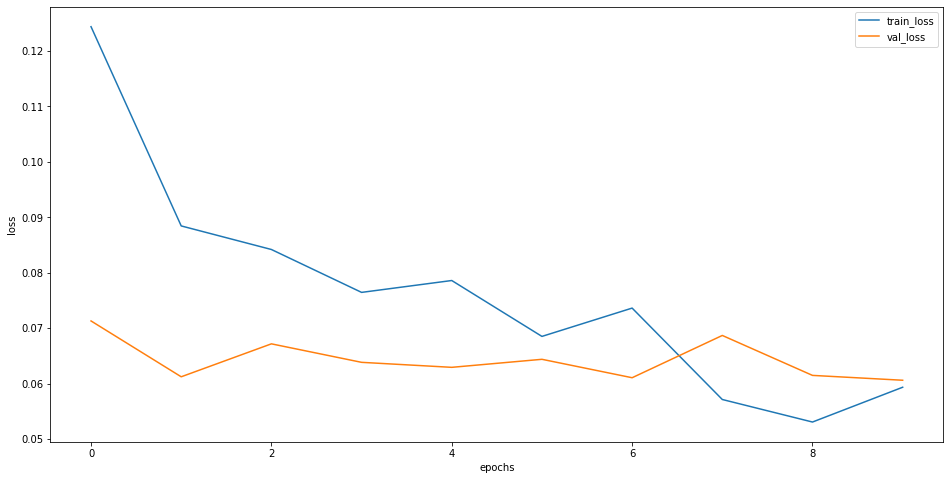

In [74]:
plt.figure(figsize=(16, 8))

plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

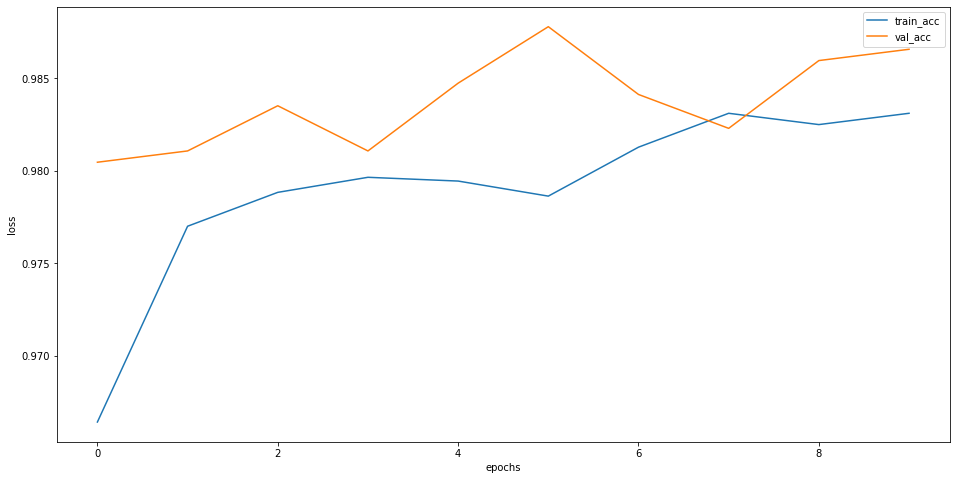

In [75]:
plt.figure(figsize=(16, 8))

plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [88]:
# def predict_one_sample(model, inputs, device=DEVICE):
#     """Предсказание, для одной картинки"""
#     with torch.no_grad():
#         inputs = inputs.to(device)
#         model.eval()
#         logit = model(inputs).cpu()
#         probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
#     return probs

In [89]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
# probs_im = predict_one_sample(CNN, ex_img.unsqueeze(0))

In [90]:
# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

# probs_ims = predict(CNN, imgs)

In [76]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [92]:
# y_pred = np.argmax(probs_ims,-1)

# actual_labels = [val_dataset[id][1] for id in idxs]

# preds_class = [label_encoder.classes_[i] for i in y_pred]

In [77]:
from sklearn.metrics import accuracy_score

def make_accuracy_score(model, n=1000):
    idxs = list(map(int, np.random.uniform(0, n, n)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]
    preds_class = list(y_pred)
    return accuracy_score(actual_labels, preds_class)

#make_accuracy_score(model=CNN)
make_accuracy_score(model=net)

0.987

In [78]:
test_dataset = FlowerDataset(test_files, mode="test", transform = valid_dataset_transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
#probs = predict(CNN, test_loader)
probs = predict(net, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [79]:
! ls

base_line_flower_06.csv  gdrive		    sample_data		   test
flowerdata-module5.zip	 label_encoder.pkl  sample_submission.csv  train


In [80]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Category': preds})
my_submit.head()

,Id,Category
0,image_00028.jpg,77
1,image_00059.jpg,77
2,image_00061.jpg,77
3,image_00063.jpg,77
4,image_00071.jpg,77


In [81]:
my_submit.to_csv('/content/base_line_flower_07.csv', index=False)